In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import beta
import timeit
from scipy.interpolate import interp1d
import scipy.stats as st

# The true distribution
We take the true distribution of $y$ to be $\mathcal{Beta}(3,3)$ drawn on $[-1,1]$. i.e. we have unormalized density
<br>
<center> $(1+y)^2(1-y)^2$

We seek to find $x^*$ such that it solves $\min_x E[c(x,y)]$ where
<br>
<center>$c(x,y) = 3x^2 + 6xy^2 - 2x^2y - 7xy$.

This can be solved analytically, whereby $x$ is minimised at $-1/7$ = -0.14286.

Text(0.5,1,'True Distribution of Y')

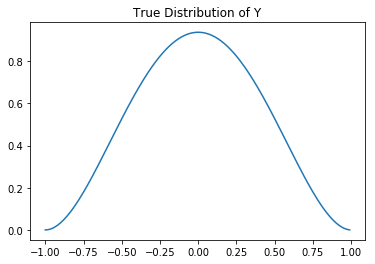

In [2]:
# Define the true distribution
Y = beta(a = 3,b=3,loc=-1,scale=2)

# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
z = Y.pdf(x)
plt.plot(x,z)
plt.title("True Distribution of Y")

In [3]:
# the cost function we would like to minimise
def f(x,y, weights=None,find_mean=True,):
    function = 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y
    if find_mean:
        if weights is not None:
            return np.average(function,axis=0,weights=weights)
        else:
            return np.mean(function,axis=0)
    else:
        return function

In [4]:
def df_dy(x,y):
    return 12*x*y - 2*x**2 - 7*x

In [5]:
def phi_div(samples,func,delta=0.1,p0=0.0,x_star=None):
    if x_star is None:
        # get initial estimate by computing SAA
        x_star = SAA_minimise(samples,func,p0)
    
    # compute the cost function
    cost = f(x_star,samples,find_mean=False)

    # get the best cost
    i_worst = np.argmin(cost)
    i_best = np.argmax(cost)
    
    # recompute x* using altered weights
    weights = np.ones((len(samples)))
    weights[i_worst] = 1.0- delta
    weights[i_best] = 1.0+delta
    res = minimize(func,p0,args=(samples,weights))
    return res.x

In [6]:
def wasserstein_metric(samples,func,delta=0.1,p0=0.0,x_star=None):
    if x_star is None:
        # get initial estimate by computing SAA
        x_star = SAA_minimise(samples,func,p0)
    
    # compute the gardient
    gradient = df_dy(x_star,samples)
    
    # get the index largest absolute gradient
    d_max_index = np.argmax(np.abs(gradient))
    
    if gradient[d_max_index] > 0:  
        samples[d_max_index] += delta
    elif gradient[d_max_index] < 0:
        samples[d_max_index] -= delta
    return SAA_minimise(samples,func,p0)    
    

In [7]:
def SAA_minimise(samples, func, p0=0.0):
    res = minimize(func,p0,args=(samples))
    return res.x

In [8]:
# Some experimental hyper parameters

# number of iterations to perform each experiment
n_iter = 60000

# number of samples for each experiment
# we use 50, 100, 150...., 5000 samples
N = [10,20,50,100,200]

# delta less than 0.01 hadly makes any difference
# delta greater than 0.05 makes no improvement
delta = [0.005,0.01,0.02]

In [9]:
%%time
SAA_results = np.zeros((n_iter,len(N)))
phi_results = np.zeros((n_iter,len(N),len(delta)))
wasserstein_results = np.zeros((n_iter,len(N),len(delta)))

#start_time = timeit.default_timer()

for k in range(n_iter):
    for j in range(len(N)):
        # obtain the samples
        S = Y.rvs(N[j])
        
        x_star = SAA_minimise(S,f)
        SAA_results[k,j] = x_star
        for i in range(len(delta)):                
            phi_results[k,j,i] = phi_div(S, f,x_star=x_star,delta=delta[i])
            wasserstein_results[k,j,i] = wasserstein_metric(S,f,x_star=x_star,delta=delta[i])
#elapsed = timeit.default_timer() - start_time
#print("This has taken %.2f seconds") %elapsed

CPU times: user 9min 53s, sys: 12 ms, total: 9min 53s
Wall time: 9min 53s


In [10]:
np.abs(np.mean(phi_results[:,:,-1],axis=0)).shape

(5,)

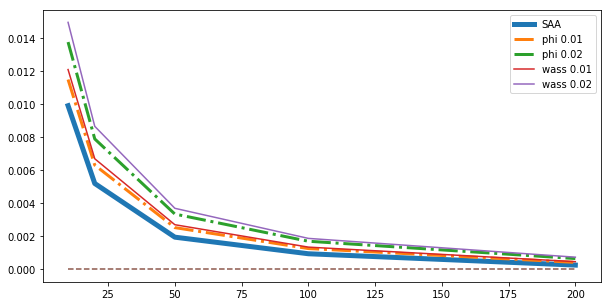

In [21]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.abs(np.mean(SAA_results,axis=0)+1.0/7),label='SSA approximation',lw=5.0,ls='-')
lineObjects += plt.plot(N,np.abs(np.mean(phi_results[:,:,1:],axis=0)+1.0/7),ls='-.',lw=3.0)
lineObjects += plt.plot(N,np.abs(np.mean(wasserstein_results[:,:,1:],axis=0)+1.0/7))
#plt.plot(N,np.abs(np.mean(SAA_results,axis=0)+1.0/7),label='SAA approximation')
#plt.plot(N,np.abs(np.mean(phi_results,axis=0)+1.0/7),label='Phi Divergence')
#plt.plot(N,np.abs(np.mean(wasserstein_results,axis=0)+1.0/7),label='Wasserstein')

plt.plot(N,[0.0]*len(N),'--',label='True value')
strings = ['phi '+ str(ele) for ele in delta][1:]
strings += ['wass '+ str(ele) for ele in delta][1:]
plt.legend(lineObjects,tuple(['SAA'] + strings + ['True value']))

In [12]:
# save data to a csv
header='10,20,50,100,200'
np.savetxt('phi_results_01.csv', phi_results[:,:,1], delimiter=',', header=header)
np.savetxt('wasser_results_01.csv', wasserstein_results[:,:,1], delimiter=',', header=header)
np.savetxt('SAA_results.csv', SAA_results, delimiter=',', header=header)

Text(0.5,1,'Standard Deviation')

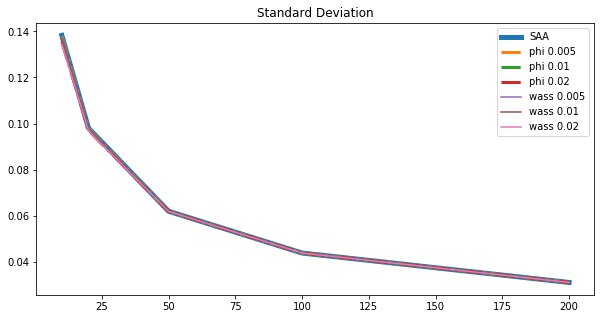

In [13]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.std(SAA_results,axis=0),label='SSA approximation',lw=5.0,ls='-')
lineObjects += plt.plot(N,np.std(phi_results[:,:,:],axis=0),ls='-.',lw=3.0)
lineObjects += plt.plot(N,np.std(wasserstein_results[:,:,:],axis=0))
#plt.plot(N,np.abs(np.mean(SAA_results,axis=0)+1.0/7),label='SAA approximation')
#plt.plot(N,np.abs(np.mean(phi_results,axis=0)+1.0/7),label='Phi Divergence')
#plt.plot(N,np.abs(np.mean(wasserstein_results,axis=0)+1.0/7),label='Wasserstein')

#plt.plot(N,[0.0]*len(N),'--',label='True value')
strings = ['phi '+ str(ele) for ele in delta]
strings += ['wass '+ str(ele) for ele in delta]
plt.legend(lineObjects,tuple(['SAA'] + strings + ['True value']))
plt.title('Standard Deviation')

In [14]:
diff_phi = np.abs(SAA_results - phi_results[:,:,1])
diff_wasser = np.abs(SAA_results - wasserstein_results[:,:,1])

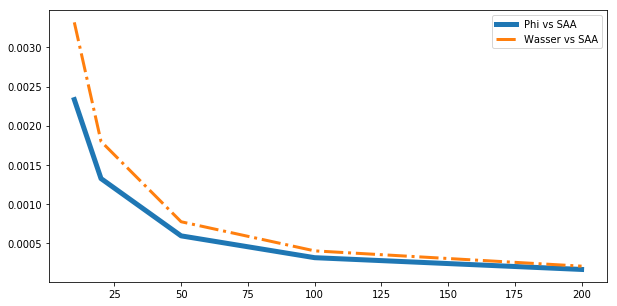

In [15]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.mean(diff_phi,axis=0),label='Phi vs SAA',lw=5.0,ls='-')
lineObjects += plt.plot(N,np.mean(diff_wasser,axis=0),label='Wasser vs SAA',ls='-.',lw=3.0)
plt.legend()

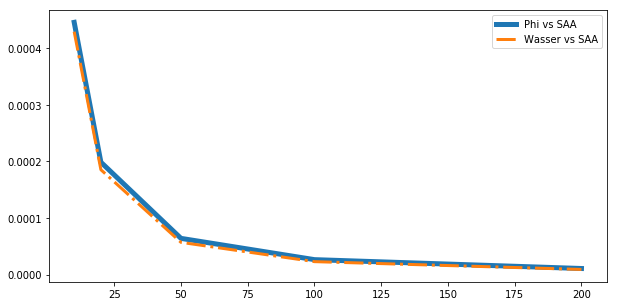

In [16]:
plt.figure(figsize=(10,5))
lineObjects = plt.plot(N,np.std(diff_phi,axis=0),label='Phi vs SAA',lw=5.0,ls='-')
lineObjects += plt.plot(N,np.std(diff_wasser,axis=0),label='Wasser vs SAA',ls='-.',lw=3.0)
plt.legend()

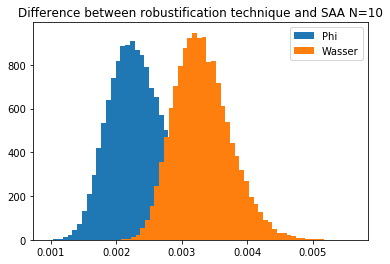

In [18]:
plt.hist(diff_phi[:,0],bins=50,normed=True,label='Phi')
plt.hist(diff_wasser[:,0],bins=50,normed=True,label='Wasser')
plt.title('Difference between robustification technique and SAA N=10')
plt.legend()

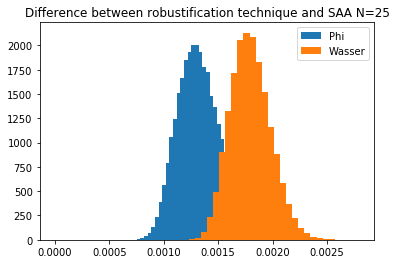

In [22]:
plt.hist(diff_phi[:,1],bins=50,normed=True,label='Phi')
plt.hist(diff_wasser[:,1],bins=50,normed=True,label='Wasser')
plt.title('Difference between robustification technique and SAA N=25')
plt.legend()

Text(0.5,1,'Difference between robustification technique and SAA N=50')

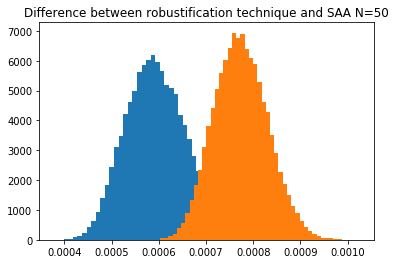

In [23]:
plt.hist(diff_phi[:,2],bins=50,normed=True,label='Phi')



plt.hist(diff_wasser[:,2],bins=50,normed=True,label='Wasser')
plt.title('Difference between robustification technique and SAA N=50')